In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import psycopg2
from sqlalchemy import create_engine

sns.set_style("whitegrid")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
connection=psycopg2.connect(host="localhost",database="sgcarmart", user="postgres", password="postgres")

engine = create_engine('postgresql://localhost:5432/sgcarmart')


query="""

    SELECT *
    FROM cars
"""


cars=pd.read_sql_query(query,engine)


In [3]:
cars.reset_index(drop=True,inplace=True)

In [4]:
cars.drop(columns=['index','level_0'],inplace=True)

In [5]:
cars=cars[cars['price'].notna()]
fill_ind=cars['org_reg_date'].notna() & cars['reg_date'].isna()
cars['reg_date'].loc[fill_ind]=cars['org_reg_date'][fill_ind]
cars=cars[cars['reg_date'].notna()]
cars['reg_date']=cars['reg_date'].apply(lambda x:datetime.datetime.strptime(x.split()[0],'%Y-%m-%d') )
cars=cars[cars['reg_date'].dt.year>2000]
cars.reset_index(drop=True,inplace=True)

In [6]:
cars['date_posted']=cars['date_posted'].apply(lambda x:datetime.datetime.strptime(x.split()[0],'%Y-%m-%d'))
cars['date_scraped']=cars['date_scraped'].apply(lambda x:datetime.datetime.strptime(x.split()[0],'%d-%m-%Y'))
cars['date_updated']=cars['date_updated'].apply(lambda x:datetime.datetime.strptime(x.split()[0],'%Y-%m-%d'))

In [7]:

cars['power']=cars[['power','brand']].groupby(cars['brand']).transform(lambda x: x.fillna(x.mean()))
cars['depreciation']=cars[['depreciation','brand']].groupby(cars['brand']).transform(lambda x: x.fillna(x.mean()))
cars['omv']=cars[['omv','brand']].groupby(cars['brand']).transform(lambda x: x.fillna(x.mean()))
cars['engine_cap']=cars[['engine_cap','type_of_veh']].groupby(cars['type_of_veh']).transform(lambda x: x.fillna(x.mean()))
cars['coe_cat']=cars['engine_cap'].apply(lambda x: 'CAT_A' if x <1600. else 'CAT_B')
cars['curb_weight']=cars[['curb_weight','type_of_veh']].groupby(cars['type_of_veh']).transform(lambda x: x.fillna(x.mean()))
cars['veh_age']=cars['date_posted'].dt.year-cars['reg_date'].dt.year
cars['veh_age_mths']=cars.date_posted.dt.to_period('M')-cars.reg_date.dt.to_period('M')

In [33]:
def latest_reg_date_my(x):
    date=''
    if x.veh_age>10:
        date=x.reg_date + datetime.timedelta(days=365.25*10)
        return date.strftime('%b-%Y')
    else:
        return x.reg_date.strftime('%b-%Y')

def latest_reg_date(x):
    if x.veh_age>10:
        return x.reg_date + datetime.timedelta(days=365.25*10)
    else:
        return x.reg_date
    
cars['reg_my']=cars[['reg_date','veh_age']].apply(lambda x: latest_reg_date_my(x),axis=1)
cars['reg_date2']=cars[['reg_date','veh_age']].apply(lambda x: latest_reg_date(x),axis=1) 

cars['month_to_coe_expiry']=cars.date_posted.dt.to_period('M')-cars.reg_date2.dt.to_period('M')
cars['month_to_coe_expiry']=cars['month_to_coe_expiry'].apply(lambda x: x.n)

In [9]:
cars['coe_my_cat']=cars['reg_my']+'-'+cars['coe_cat']

In [10]:
coe=pd.read_csv('./data/master/COE_2000-2019.csv')

In [11]:
coe['MY']=coe['Month']+'-'+coe['Year'].astype(str)
coe_long=coe[['CAT_A', 'CAT_B','MY']].melt(id_vars='MY')
coe_long['coe_my_cat']=coe_long['MY']+'-'+coe_long['variable']
coe_fill=coe_long[['coe_my_cat','value']]
coe_miss=pd.merge(cars[['coe_my_cat','coe']][cars['coe'].isna()],coe_fill,on='coe_my_cat',right_index=True)
cars['coe'].fillna(value=coe_miss['value'],inplace=True)

In [12]:
def arf_calculator(x):
    arf=20000
    if x<=20000:
        return arf
    if 20000<x<=50000:
        return arf + 1.4*(x-arf)
    if x>50000:
        return arf + 1.4*(x-arf) +1.8*(x-50000)
cars['arf'].fillna(cars['omv'][cars['arf'].isna()].apply(lambda x: arf_calculator(x)),inplace=True)


In [13]:
def road_tax_calculator(x):
    base=0
    if x.engine_cap<=600:
        base=400*0.782
    if 600 < x.engine_cap <=1000:
        base=(400 + 0.25*(x.engine_cap - 600))*0.782
    if 1000 < x.engine_cap <= 1600:
        base=(500 + 0.75*(x.engine_cap - 1000))*0.782
    if 1600 < x.engine_cap <= 3000:
        base=(950 + 1.5*(x.engine_cap - 1600))*0.782
    if x.engine_cap>3000:
        base=(3050 + 2*(x.engine_cap-3000))*0.782
        
    if x.veh_age>10:
        return base*(1+0.1*(x.veh_age-10))
    else:
        return base
    
cars['road_tax'].fillna(cars[['engine_cap','veh_age']][cars['road_tax'].isna()].apply(lambda x: road_tax_calculator(x),axis=1),inplace=True)

In [34]:
cars['coe_rebate']=cars['coe']*cars['month_to_coe_expiry']/120

In [35]:
def parf_calculator(x):
    if x.veh_age<5:
        return 0.75*(x.arf)
    if 5<=x.veh_age<10:
        return (0.75-0.05*(x.veh_age-4))*(x.arf)
    if x.veh_age>=10:
        return 0
cars['parf_rebate']=cars[['veh_age','arf']].apply(lambda x: parf_calculator(x),axis=1)
cars['dereg_value'].fillna(cars['parf_rebate'][cars['dereg_value'].isna()]+cars['coe_rebate'][cars['dereg_value'].isna()],inplace=True)

In [36]:
cars['no_of_owners'].fillna(1,inplace=True)
cars['depreciation'].fillna(cars['depreciation'].mean(),inplace=True)

In [37]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24330 entries, 0 to 24329
Data columns (total 46 columns):
accessories             21817 non-null object
additional              162 non-null object
arf                     24330 non-null float64
auction_closing_time    40 non-null object
availability            24330 non-null object
brand                   24330 non-null object
car_tags                24330 non-null object
category                24330 non-null object
coe                     24330 non-null float64
curb_weight             24330 non-null float64
date_posted             24330 non-null datetime64[ns]
date_scraped            24330 non-null datetime64[ns]
date_updated            24330 non-null datetime64[ns]
days_to_sell            13530 non-null float64
depreciation            24330 non-null float64
dereg_value             24330 non-null float64
description             23403 non-null object
engine_cap              24330 non-null float64
features                21920 non-nul

In [38]:
car_type_dummies=cars['category'].str.get_dummies(sep=', ')

In [39]:
labels=car_type_dummies.columns
car_type_dummies.columns=['is_'+x.lower().replace(' ','_') for x in labels]

In [41]:
cars=pd.concat([cars,car_type_dummies],axis=1)

In [79]:
import plotly
import cufflinks as cf
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [80]:
plotly.tools.set_credentials_file(username='zacharyang', api_key='FJbH2NYjhDXkF2Bup9PW')

In [48]:
@interact
def show_price(column='price',x=50000):
    return cars[['list_title','brand','price']].loc[cars['price']>x]

interactive(children=(Text(value='price', description='column'), IntSlider(value=50000, description='x', max=1…

In [90]:

@interact
def scatter_plot(x=list(cars.select_dtypes('number').columns), 
                 y=list(cars.select_dtypes('number').columns),
                style=['darkgrid','whitegrid','dark','white']):
    sns.set_style(style)
    plt.figure(figsize=(10,8))
    sns.scatterplot(x=x,y=y,data=cars)

interactive(children=(Dropdown(description='x', options=('arf', 'coe', 'curb_weight', 'days_to_sell', 'depreci…

In [93]:
@interact
def scatter_plot(x=list(cars.select_dtypes('number').columns), 
                 y=list(cars.select_dtypes('number').columns),
                theme=list(cf.themes.THEMES.keys()), 
                 colorscale=list(cf.colors._scales_names.keys())):
    
    cars.iplot(kind='scatter',x=x,y=y,mode='markers',title='{} vs {}'.format(x.title(),y.title()))
    

interactive(children=(Dropdown(description='x', options=('arf', 'coe', 'curb_weight', 'days_to_sell', 'depreci…

In [97]:
cars.iplot(kind='scatter',x='arf',y='price',categories='brand',mode='markers')

/Users/zachang/Documents/Data/cars-project/env/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [ ]:
sns.set_style.

In [83]:
cars.iplot(kind='bubble',x='veh_age',y='mileage',size='price')

/Users/zachang/Documents/Data/cars-project/env/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [36]:
from sklearn.linear_model import LinearRegression

In [39]:
m=cars['mileage'][cars['mileage'].notna()]
age_lm=cars['veh_age_mths'][cars['mileage'].notna()]*cars['is_low_mileage_car'][cars['mileage'].notna()]
X=pd.concat([cars[['veh_age_mths','is_low_mileage_car']][cars['mileage'].notna()],age_lm],axis=1).values

In [40]:
lr_impute=LinearRegression().fit(X,m)

In [42]:
X_miss=cars[['veh_age_mths','is_low_mileage_car']][cars['mileage'].isna()]
X_miss['interaction']=cars['veh_age_mths'][cars['mileage'].isna()]*cars['is_low_mileage_car'][cars['mileage'].isna()]

In [43]:
mileage_miss=pd.Series(lr_impute.predict(X_miss),index=cars['mileage'][cars['mileage'].isna()].index)

In [44]:
mileage_miss

0         16552.196951
8        115835.896682
21        91243.357808
22       123008.720520
31       112761.829323
32        66650.818934
34       100465.559885
37       120959.342281
38       107638.383724
46       137354.368197
47        97391.492526
52       169119.730909
53       118909.964041
64       107638.383724
66       103539.627245
69        40008.901820
70        41033.590940
71        51280.482137
80        60502.684215
81        99440.870766
83        61527.373335
91        22589.186784
94       137354.368197
95        42058.280059
97        67675.508053
98       135304.989957
100       66650.818934
102       48206.414778
104       52695.912736
108       95342.114287
             ...      
24091    137354.368197
24093     25663.254143
24097    139403.746436
24116    136329.679077
24123     49231.103898
24129    136329.679077
24155     94317.425167
24158    158872.839712
24164    135304.989957
24172    136329.679077
24196    126082.787879
24199    134280.300837
24206    13

In [688]:
cars['mileage'][cars['mileage'].isna()]=mileage_miss

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


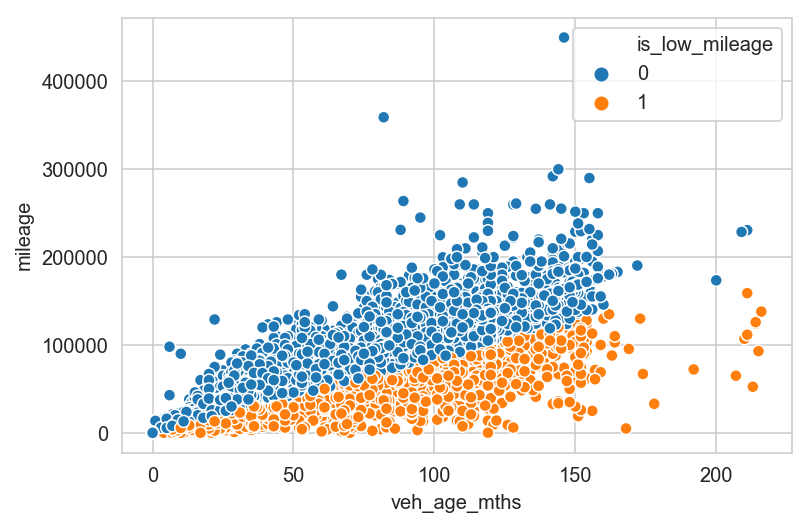

In [690]:
sns.scatterplot(x='veh_age_mths',y='mileage',data=cars,hue='is_low_mileage')